In [1]:
from cnn import Conv, ReLU, MaxPool, LinearLayer, SoftMaxCrossEntropyLoss

In [2]:
class ConvNet2:
    def __init__(self):
        self.conv1 = Conv(input_shape=(3, 32, 32), filter_shape=(5, 5, 5))
        self.relu1 = ReLU()
        self.pool1 = MaxPool(filter_shape=(2, 2), stride=2)
        self.conv2 = Conv(input_shape=(5, 16, 16), filter_shape=(5, 5, 5))
        self.relu2 = ReLU()
        self.pool2 = MaxPool(filter_shape=(2, 2), stride=2)
        self.linear1 = LinearLayer(8*8*5, 20)
        self.loss = SoftMaxCrossEntropyLoss()

    def forward(self, inputs, y_labels):
        self.batch = inputs.shape[0]
        x = self.conv1.forward(inputs, stride=1, pad=2)
        x = self.relu1.forward(x)
        x = self.pool1.forward(x)
        x = self.conv2.forward(x, stride=1, pad=2)
        x = self.relu2.forward(x)
        x = self.pool2.forward(x)
        yhat = self.linear1.forward(x.reshape(self.batch, -1))
        l, preds = self.loss.forward(yhat, y_labels, get_predictions=True)
        return l, preds

    def backward(self):
        d = self.loss.backward()
        dw, db, d = self.linear1.backward(d)
        d = d.reshape(self.batch, 5, 8, 8)
        d = self.pool2.backward(d)
        d = self.relu2.backward(d)
        dw, db, d = self.conv2.backward(d)
        d = self.pool1.backward(d)
        d = self.relu1.backward(d)
        dw, db, d = self.conv1.backward(d)

    def update(self, learning_rate, momentum_coeff):
        self.linear1.update(learning_rate, momentum_coeff)
        self.conv2.update(learning_rate, momentum_coeff)
        self.conv1.update(learning_rate, momentum_coeff)

In [3]:
import pickle
import tqdm
from cnn import labels2onehot
import numpy as np

epochs = 100
batch_size = 32
lr = 0.002
mom = 0.9

with open("data.pkl", "rb") as f:
    data = pickle.load(f)

train, test = data["train"], data["test"]
xtrain, ytrain = train['data'], labels2onehot(train['labels'])
xtest, ytest = test['data'], labels2onehot(test['labels'])

print('# of train points:', xtrain.shape[0])

# of train points: 8000


In [5]:
conv2 = ConvNet2()

train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in tqdm.tqdm_notebook(range(epochs)):
    indices = np.arange(xtrain.shape[0])
    np.random.shuffle(indices)
    bar = tqdm.tqdm_notebook(range(0, indices.shape[0], batch_size))
    for i in bar:
        y = ytrain[indices[i: i + batch_size]]
        l, preds = conv2.forward(xtrain[indices[i: i + batch_size], :], y)
        conv2.backward()
        conv2.update(learning_rate=lr, momentum_coeff=mom)

    train_loss = 0
    train_acc = 0
    bb = 2000
    for i in tqdm.tqdm_notebook(range(0, xtrain.shape[0], bb), desc='evaling'):
        tl, preds=conv2.forward(xtrain[i:i+bb], ytrain[i:i+bb])
        train_acc+=np.sum(np.argmax(ytrain[i:i+bb, :], axis=-1)==preds)
        train_loss += tl
    train_acc /= xtrain.shape[0]
    train_loss /= xtrain.shape[0]

    test_loss, test_preds = conv2.forward(xtest, ytest)
    test_loss /= xtest.shape[0]
    test_acc = np.mean(np.argmax(ytest, axis=-1) == test_preds)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    tqdm.tqdm.write("Epoch {0} :: Train Loss {1:.2f} :: Train Acc {2:.2f}".format(epoch+1,
                                                                                  train_loss,
                                                                                  train_acc)\
                    +" :: Test Loss {0:.2f} :: Test Acc {1:.2f}".format(test_loss,
                                                                        test_acc))

<ipython-input-5-909806995a48>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(epochs)):


<ipython-input-5-909806995a48>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  bar = tqdm.tqdm_notebook(range(0, indices.shape[0], batch_size))


<ipython-input-5-909806995a48>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(0, xtrain.shape[0], bb), desc='evaling'):



Epoch 1 :: Train Loss 2.89 :: Train Acc 0.13 :: Test Loss 2.88 :: Test Acc 0.12



Epoch 2 :: Train Loss 2.69 :: Train Acc 0.19 :: Test Loss 2.68 :: Test Acc 0.18



Epoch 3 :: Train Loss 2.63 :: Train Acc 0.20 :: Test Loss 2.64 :: Test Acc 0.20



Epoch 4 :: Train Loss 2.57 :: Train Acc 0.23 :: Test Loss 2.58 :: Test Acc 0.22



Epoch 5 :: Train Loss 2.55 :: Train Acc 0.23 :: Test Loss 2.57 :: Test Acc 0.24



Epoch 6 :: Train Loss 2.50 :: Train Acc 0.25 :: Test Loss 2.54 :: Test Acc 0.24



Epoch 7 :: Train Loss 2.46 :: Train Acc 0.26 :: Test Loss 2.51 :: Test Acc 0.26



Epoch 8 :: Train Loss 2.47 :: Train Acc 0.25 :: Test Loss 2.51 :: Test Acc 0.26



Epoch 9 :: Train Loss 2.41 :: Train Acc 0.27 :: Test Loss 2.48 :: Test Acc 0.26



Epoch 10 :: Train Loss 2.39 :: Train Acc 0.29 :: Test Loss 2.49 :: Test Acc 0.24



Epoch 11 :: Train Loss 2.35 :: Train Acc 0.30 :: Test Loss 2.47 :: Test Acc 0.27



Epoch 12 :: Train Loss 2.32 :: Train Acc 0.31 :: Test Loss 2.45 :: Test Acc 0.26



Epoch 13 :: Train Loss 2.39 :: Train Acc 0.29 :: Test Loss 2.53 :: Test Acc 0.27



Epoch 14 :: Train Loss 2.29 :: Train Acc 0.31 :: Test Loss 2.42 :: Test Acc 0.29



Epoch 15 :: Train Loss 2.29 :: Train Acc 0.31 :: Test Loss 2.44 :: Test Acc 0.27



Epoch 16 :: Train Loss 2.25 :: Train Acc 0.33 :: Test Loss 2.42 :: Test Acc 0.29



Epoch 17 :: Train Loss 2.21 :: Train Acc 0.34 :: Test Loss 2.38 :: Test Acc 0.31



Epoch 18 :: Train Loss 2.26 :: Train Acc 0.32 :: Test Loss 2.46 :: Test Acc 0.28



Epoch 19 :: Train Loss 2.20 :: Train Acc 0.35 :: Test Loss 2.40 :: Test Acc 0.31



Epoch 20 :: Train Loss 2.19 :: Train Acc 0.35 :: Test Loss 2.40 :: Test Acc 0.32



Epoch 21 :: Train Loss 2.16 :: Train Acc 0.35 :: Test Loss 2.41 :: Test Acc 0.30



Epoch 22 :: Train Loss 2.17 :: Train Acc 0.35 :: Test Loss 2.39 :: Test Acc 0.31



Epoch 23 :: Train Loss 2.13 :: Train Acc 0.35 :: Test Loss 2.40 :: Test Acc 0.27



Epoch 24 :: Train Loss 2.07 :: Train Acc 0.38 :: Test Loss 2.33 :: Test Acc 0.32



Epoch 25 :: Train Loss 2.10 :: Train Acc 0.36 :: Test Loss 2.39 :: Test Acc 0.29



Epoch 26 :: Train Loss 2.07 :: Train Acc 0.37 :: Test Loss 2.36 :: Test Acc 0.30



Epoch 27 :: Train Loss 2.02 :: Train Acc 0.39 :: Test Loss 2.33 :: Test Acc 0.31



Epoch 28 :: Train Loss 2.00 :: Train Acc 0.40 :: Test Loss 2.31 :: Test Acc 0.30



Epoch 29 :: Train Loss 1.99 :: Train Acc 0.40 :: Test Loss 2.34 :: Test Acc 0.31



Epoch 30 :: Train Loss 1.99 :: Train Acc 0.40 :: Test Loss 2.35 :: Test Acc 0.30



Epoch 31 :: Train Loss 2.01 :: Train Acc 0.40 :: Test Loss 2.37 :: Test Acc 0.32



Epoch 32 :: Train Loss 1.96 :: Train Acc 0.41 :: Test Loss 2.32 :: Test Acc 0.32



Epoch 33 :: Train Loss 1.93 :: Train Acc 0.41 :: Test Loss 2.32 :: Test Acc 0.32



Epoch 34 :: Train Loss 2.00 :: Train Acc 0.40 :: Test Loss 2.41 :: Test Acc 0.29



Epoch 35 :: Train Loss 1.96 :: Train Acc 0.41 :: Test Loss 2.36 :: Test Acc 0.31



Epoch 36 :: Train Loss 1.93 :: Train Acc 0.42 :: Test Loss 2.36 :: Test Acc 0.30



Epoch 37 :: Train Loss 1.95 :: Train Acc 0.41 :: Test Loss 2.40 :: Test Acc 0.30



Epoch 38 :: Train Loss 1.94 :: Train Acc 0.42 :: Test Loss 2.38 :: Test Acc 0.31



Epoch 39 :: Train Loss 1.93 :: Train Acc 0.42 :: Test Loss 2.43 :: Test Acc 0.31



Epoch 40 :: Train Loss 1.90 :: Train Acc 0.43 :: Test Loss 2.40 :: Test Acc 0.30



Epoch 41 :: Train Loss 1.90 :: Train Acc 0.43 :: Test Loss 2.42 :: Test Acc 0.29



Epoch 42 :: Train Loss 1.87 :: Train Acc 0.44 :: Test Loss 2.39 :: Test Acc 0.32



Epoch 43 :: Train Loss 1.84 :: Train Acc 0.44 :: Test Loss 2.38 :: Test Acc 0.32



Epoch 44 :: Train Loss 1.83 :: Train Acc 0.45 :: Test Loss 2.37 :: Test Acc 0.31



Epoch 45 :: Train Loss 1.84 :: Train Acc 0.44 :: Test Loss 2.36 :: Test Acc 0.31



Epoch 46 :: Train Loss 1.80 :: Train Acc 0.46 :: Test Loss 2.40 :: Test Acc 0.29



Epoch 47 :: Train Loss 1.81 :: Train Acc 0.45 :: Test Loss 2.39 :: Test Acc 0.30



Epoch 48 :: Train Loss 1.81 :: Train Acc 0.45 :: Test Loss 2.43 :: Test Acc 0.31



Epoch 49 :: Train Loss 1.79 :: Train Acc 0.46 :: Test Loss 2.40 :: Test Acc 0.30



Epoch 50 :: Train Loss 1.78 :: Train Acc 0.46 :: Test Loss 2.39 :: Test Acc 0.31



Epoch 51 :: Train Loss 1.75 :: Train Acc 0.47 :: Test Loss 2.41 :: Test Acc 0.30



Epoch 52 :: Train Loss 1.80 :: Train Acc 0.46 :: Test Loss 2.46 :: Test Acc 0.29



Epoch 53 :: Train Loss 1.79 :: Train Acc 0.46 :: Test Loss 2.40 :: Test Acc 0.32



Epoch 54 :: Train Loss 1.77 :: Train Acc 0.46 :: Test Loss 2.48 :: Test Acc 0.30



Epoch 55 :: Train Loss 1.77 :: Train Acc 0.46 :: Test Loss 2.44 :: Test Acc 0.32



Epoch 56 :: Train Loss 1.77 :: Train Acc 0.47 :: Test Loss 2.44 :: Test Acc 0.29



Epoch 57 :: Train Loss 1.77 :: Train Acc 0.47 :: Test Loss 2.50 :: Test Acc 0.31



Epoch 58 :: Train Loss 1.74 :: Train Acc 0.47 :: Test Loss 2.45 :: Test Acc 0.33



Epoch 59 :: Train Loss 1.76 :: Train Acc 0.47 :: Test Loss 2.50 :: Test Acc 0.28



Epoch 60 :: Train Loss 1.71 :: Train Acc 0.48 :: Test Loss 2.48 :: Test Acc 0.31



Epoch 61 :: Train Loss 1.72 :: Train Acc 0.48 :: Test Loss 2.46 :: Test Acc 0.30



Epoch 62 :: Train Loss 1.75 :: Train Acc 0.47 :: Test Loss 2.50 :: Test Acc 0.33



Epoch 63 :: Train Loss 1.73 :: Train Acc 0.48 :: Test Loss 2.51 :: Test Acc 0.30



Epoch 64 :: Train Loss 1.74 :: Train Acc 0.47 :: Test Loss 2.49 :: Test Acc 0.32



Epoch 65 :: Train Loss 1.73 :: Train Acc 0.48 :: Test Loss 2.50 :: Test Acc 0.30



Epoch 66 :: Train Loss 1.70 :: Train Acc 0.49 :: Test Loss 2.50 :: Test Acc 0.32



Epoch 67 :: Train Loss 1.71 :: Train Acc 0.48 :: Test Loss 2.54 :: Test Acc 0.30



Epoch 68 :: Train Loss 1.70 :: Train Acc 0.48 :: Test Loss 2.51 :: Test Acc 0.32



Epoch 69 :: Train Loss 1.67 :: Train Acc 0.49 :: Test Loss 2.52 :: Test Acc 0.30



Epoch 70 :: Train Loss 1.71 :: Train Acc 0.48 :: Test Loss 2.57 :: Test Acc 0.31



Epoch 71 :: Train Loss 1.73 :: Train Acc 0.47 :: Test Loss 2.61 :: Test Acc 0.28



Epoch 72 :: Train Loss 1.68 :: Train Acc 0.49 :: Test Loss 2.60 :: Test Acc 0.28



Epoch 73 :: Train Loss 1.64 :: Train Acc 0.50 :: Test Loss 2.55 :: Test Acc 0.29



Epoch 74 :: Train Loss 1.63 :: Train Acc 0.50 :: Test Loss 2.57 :: Test Acc 0.30



Epoch 75 :: Train Loss 1.64 :: Train Acc 0.51 :: Test Loss 2.54 :: Test Acc 0.29



Epoch 76 :: Train Loss 1.62 :: Train Acc 0.51 :: Test Loss 2.50 :: Test Acc 0.32



Epoch 77 :: Train Loss 1.66 :: Train Acc 0.50 :: Test Loss 2.55 :: Test Acc 0.32



Epoch 78 :: Train Loss 1.63 :: Train Acc 0.51 :: Test Loss 2.56 :: Test Acc 0.31



Epoch 79 :: Train Loss 1.65 :: Train Acc 0.50 :: Test Loss 2.60 :: Test Acc 0.32



Epoch 80 :: Train Loss 1.63 :: Train Acc 0.50 :: Test Loss 2.54 :: Test Acc 0.30



Epoch 81 :: Train Loss 1.66 :: Train Acc 0.49 :: Test Loss 2.66 :: Test Acc 0.26



Epoch 82 :: Train Loss 1.63 :: Train Acc 0.51 :: Test Loss 2.59 :: Test Acc 0.27



Epoch 83 :: Train Loss 1.62 :: Train Acc 0.51 :: Test Loss 2.57 :: Test Acc 0.29



Epoch 84 :: Train Loss 1.64 :: Train Acc 0.50 :: Test Loss 2.63 :: Test Acc 0.28



Epoch 85 :: Train Loss 1.62 :: Train Acc 0.51 :: Test Loss 2.55 :: Test Acc 0.31



Epoch 86 :: Train Loss 1.60 :: Train Acc 0.51 :: Test Loss 2.65 :: Test Acc 0.28



Epoch 87 :: Train Loss 1.58 :: Train Acc 0.52 :: Test Loss 2.56 :: Test Acc 0.31



Epoch 88 :: Train Loss 1.59 :: Train Acc 0.52 :: Test Loss 2.56 :: Test Acc 0.29



Epoch 89 :: Train Loss 1.59 :: Train Acc 0.51 :: Test Loss 2.59 :: Test Acc 0.30



Epoch 90 :: Train Loss 1.57 :: Train Acc 0.52 :: Test Loss 2.59 :: Test Acc 0.31



Epoch 91 :: Train Loss 1.57 :: Train Acc 0.52 :: Test Loss 2.64 :: Test Acc 0.28



Epoch 92 :: Train Loss 1.62 :: Train Acc 0.50 :: Test Loss 2.61 :: Test Acc 0.32



Epoch 93 :: Train Loss 1.56 :: Train Acc 0.52 :: Test Loss 2.62 :: Test Acc 0.31



Epoch 94 :: Train Loss 1.55 :: Train Acc 0.53 :: Test Loss 2.60 :: Test Acc 0.30



Epoch 95 :: Train Loss 1.57 :: Train Acc 0.52 :: Test Loss 2.65 :: Test Acc 0.28



Epoch 96 :: Train Loss 1.55 :: Train Acc 0.53 :: Test Loss 2.60 :: Test Acc 0.29



Epoch 97 :: Train Loss 1.62 :: Train Acc 0.50 :: Test Loss 2.74 :: Test Acc 0.29



Epoch 98 :: Train Loss 1.55 :: Train Acc 0.53 :: Test Loss 2.61 :: Test Acc 0.29



Epoch 99 :: Train Loss 1.61 :: Train Acc 0.51 :: Test Loss 2.62 :: Test Acc 0.32



Epoch 100 :: Train Loss 1.54 :: Train Acc 0.53 :: Test Loss 2.65 :: Test Acc 0.27



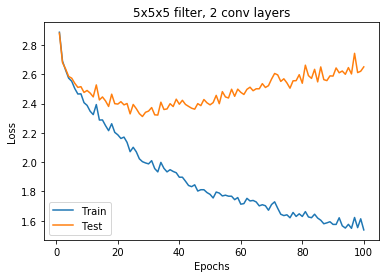

In [7]:
from matplotlib import pyplot as plt

plt.plot(list(range(1, epochs+1)), train_losses, label='Train')
plt.plot(list(range(1, epochs+1)), test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('5x5x5 filter, 2 conv layers')
plt.savefig('img/5filter_2conv_loss.png')

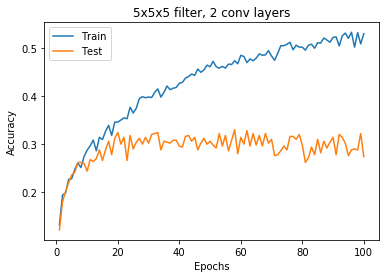

In [8]:
plt.plot(list(range(1, epochs+1)), train_accs, label='Train')
plt.plot(list(range(1, epochs+1)), test_accs, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('5x5x5 filter, 2 conv layers')
plt.savefig('img/5filter_2conv_acc.png')

In [9]:
data = {'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'test_accs': test_accs}

In [10]:
import json
with open('results/5filter_2conv.json', "w") as f:
    json.dump(data, f)

In [11]:
print(np.max(data['train_accs']))
print(np.max(data['test_accs']))

0.532125
0.33
